### Introduction
This exam assesses the candidate's ability to implement and apply Graph Neural Networks (GNNs) for the task of link prediction using PyTorch and `torch_geometric`. The dataset to be used is the MovieLens 100K dataset. Candidates will demonstrate their understanding of GNN concepts, dataset preparation, model implementation, training, and evaluation specific to link prediction tasks.

### Exam Components

#### 1. Environment Setup
- **Objective:** Ensure the Python environment is prepared for working with GNNs, focusing on `torch_geometric`.
- **Tasks:**
    1. Install `torch_geometric` and any other required libraries.
    2. Successfully import the libraries in the notebook.

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import string
import re

import matplotlib.pyplot as plt

params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 8),
          'figure.dpi': 100,
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 15.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.4 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-vsmutimq
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-vsmutimq
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit fbafbc4fc9181e8759ec1f39d9618992793b5fe1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.6.0-py3-none-any.whl

#### 2. Dataset Preparation
- **Objective:** Prepare the MovieLens 100K dataset for a link prediction task.
- **Tasks:**
    1. Download the MovieLens 100K dataset.
    2. Load the dataset and preprocess it to construct a graph where nodes represent movies and users, and edges represent ratings. Edge features can include the rating value.

In [ ]:
# Download and unzip the dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -o ml-latest-small.zip

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

--2024-07-10 08:58:12--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.69MB/s    in 0.3s    

2024-07-10 08:58:13 (2.69 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
# Load the ratings and the movies file
ratings_df = pd.read_csv(
    ratings_path, usecols=['userId', 'movieId', 'rating']
)
print(ratings_df.head())

movies_df  = pd.read_csv(
    movies_path, usecols=['movieId', 'title', 'genres']
)
print(movies_df.head())

   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


<Axes: xlabel='rating', ylabel='count'>

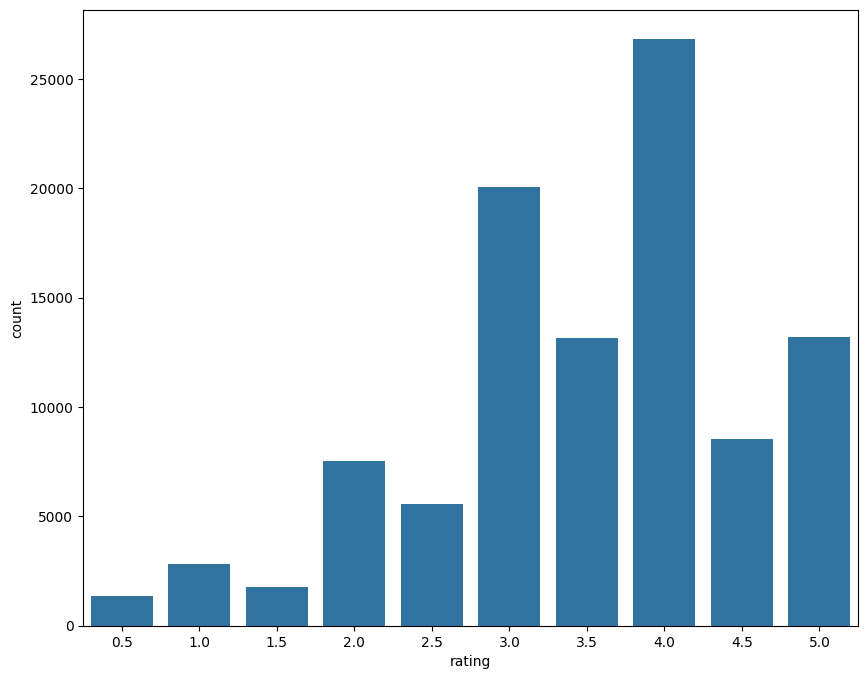

In [ ]:
sns.countplot(x='rating', data=ratings_df)

#### 2. Dataset Preparation
- **Objective:** Prepare the MovieLens 100K dataset for a link prediction task.
- **Tasks:**
    3. Utilize the `torch_geometric.data.Data` class to structure the graph data for processing by your GNN model. This includes:
        - Creating a `Data` object that encapsulates the graph's nodes, edges, and any associated features.
        - Defining the `edge_index` tensor to represent the graph's connectivity. This tensor indexes nodes and defines which nodes are connected by edges.
        - Optionally including node features (such as user or movie attributes) and edge features (such as ratings) to potentially enhance model performance.
        - Note: Unlike traditional supervised learning tasks, you will train the model in a transductive manner where the model learns to predict links directly on the entire graph. This approach reflects the real-world application of link prediction, where the model makes predictions on the same graph it was trained on.


In [ ]:
# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())
# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 9742 movies and 20 genres in total.

   Action  Adventure  Drama  Horror
0       0          1      0       0
1       0          1      0       0
2       0          0      0       0
3       0          0      1       0
4       0          0      0       0


In [ ]:
# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()


# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())
# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)


Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        3         1
2        6         2
3       47         3
4       50         4

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])


In [ ]:
# Use rating as edge features: ale
edge_rating = torch.from_numpy((ratings_df['rating'].to_numpy())).to(torch.float)

print(edge_rating)
print(edge_rating.size())

tensor([4., 4., 4.,  ..., 5., 5., 3.])
torch.Size([100836])


In [ ]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))
# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie

# add edge features -> considerare le feature e' opzinale nel task del prof
data["user", "rates", "movie"].edge_weight = edge_rating

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)



#### 3. Model Implementation
- **Objective:** Implement a GNN model suitable for link prediction.
- **Tasks:**
    1. Define a GNN architecture that can effectively learn to predict the existence of a link between two nodes.
    2. Utilize layers and techniques optimized for link prediction, such as message passing and graph pooling, to manage the graph's structure and features.

In [ ]:
# Constants and Hyperparameters   (FROM Professor)
# GCN_LAYERS = 1  # Number of GCN Layers
# HIDDEN_DIM = 128  # Number of hidden neurons in each GCN Layer
# LEARNING_RATE = 1e-3
# WEIGHT_DECAY = 5e-4
# MAX_EPOCHS = 4000
# BATCH_SIZE = 32
# LOG_EVERY_N_STEPS = 10
# NUM_NEGATIVE_SAMPLES = 3
# RANDOM_STATE = 42

GCN_LAYERS = 2  # Number of GCN Layers # modificato ale
HIDDEN_DIM = 64  # Number of hidden neurons in each GCN Layer
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
MAX_EPOCHS = 4000
BATCH_SIZE = 128          # modificato ale
LOG_EVERY_N_STEPS = 10
NUM_NEGATIVE_SAMPLES = 3
RANDOM_STATE = 42

In [ ]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)
train_data, val_data, test_data = transform(data)

In [ ]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    weight_attr='edge_weight',
    batch_size=128,
    shuffle=True,
)

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    # def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor, edge_weight: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        # return (edge_feat_user * edge_feat_movie * edge_weight[0]).sum(dim=-1) # non funziona perchè sono tutti i pesi.

        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
            data["user", "rates", "movie"].edge_weight, # per ora non usato, serve?
        )
        return pred

model = Model(hidden_channels=64)

#### 4. Model Training and Evaluation
- **Objective:** Train the GNN model in a transductive setting and evaluate its performance on the link prediction task.
- **Tasks:**
    1. Implement the training loop, applying the model to the entire graph and using techniques suitable for link prediction, including handling of positive and negative edge samples.
    2. Utilize appropriate evaluation metrics to assess model performance on predicting the presence or absence of links.
    3. Reflect on the model's predictions and the practical implications of its performance within the context of the MovieLens dataset.


In [ ]:
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 190/190 [00:06<00:00, 28.88it/s]


Epoch: 001, Loss: 0.4391


100%|██████████| 190/190 [00:05<00:00, 33.90it/s]


Epoch: 002, Loss: 0.3466


100%|██████████| 190/190 [00:06<00:00, 28.54it/s]


Epoch: 003, Loss: 0.3300


100%|██████████| 190/190 [00:05<00:00, 33.51it/s]


Epoch: 004, Loss: 0.3156


100%|██████████| 190/190 [00:06<00:00, 28.63it/s]

Epoch: 005, Loss: 0.2984


In [ ]:
# Define the validation seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

In [ ]:
from sklearn.metrics import roc_auc_score
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 79/79 [00:00<00:00, 181.18it/s]

Validation AUC: 0.9285


### Additional Considerations
- Discuss the handling of node features and the significance of edge features in the context of link prediction.
- Explore various GNN architectures, detailing the rationale behind the chosen model structure and parameters.

### Submission Guidelines
- Complete the tasks within a Colab notebook.
- Comment your code thoroughly to elucidate your implementation choices and methodologies.
- Ensure that the notebook can be executed from start to end without errors.
- Accompany the notebook with a brief report summarizing your approach, findings, and any encountered challenges.